In [22]:
# import
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset, random_split

In [2]:
# wide screen
from IPython.core.display import display, HTML
from IPython import get_ipython as get_ipython
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important;margin-left:-30px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

# Data load and preproc

In [27]:
df = pd.read_csv('/Users/andrey.golda/Documents/Study/NN/job_5067/output/3M_epgg.csv')
pd.concat([df.dtypes, df.isnull().sum()], axis=1)
df.head(3)

,p_x_e,p_y_e,p_z_e,p_x_g1,p_y_g1,p_z_g1,p_x_g2,p_y_g2,p_z_g2,p_x_p,p_y_p,p_z_p
0,-0.690989,0.103835,5.51422,0.089400,0.045746,0.269585,-0.030107,0.087844,0.412633,0.631697,-0.237425,0.338562
1,0.171885,0.790657,5.55251,0.000561,-0.178669,0.041795,0.161253,-0.302007,0.173096,-0.333699,-0.309982,0.767596
2,0.561344,0.620206,5.75845,-0.015134,-0.023590,0.063544,0.077784,-0.187364,0.029703,-0.623994,-0.409252,0.683299


In [123]:
class DatasetPi0(Dataset):
    def __init__(self, df):
        self.df = df
        self.p_x_e=torch.tensor(df.p_x_e,dtype=torch.float32)
        self.p_y_e=torch.tensor(df.p_y_e,dtype=torch.float32)
        self.p_z_e=torch.tensor(df.p_z_e,dtype=torch.float32)
        self.p_x_g1=torch.tensor(df.p_x_g1,dtype=torch.float32)
        self.p_y_g1=torch.tensor(df.p_y_g1,dtype=torch.float32)
        self.p_z_g1=torch.tensor(df.p_z_g1,dtype=torch.float32)
        self.p_x_g2=torch.tensor(df.p_x_g2,dtype=torch.float32)
        self.p_y_g2=torch.tensor(df.p_y_g2,dtype=torch.float32)
        self.p_z_g2=torch.tensor(df.p_z_g2,dtype=torch.float32)
        self.p_x_p=torch.tensor(df.p_x_p,dtype=torch.float32)
        self.p_y_p=torch.tensor(df.p_y_p,dtype=torch.float32)
        self.p_z_p=torch.tensor(df.p_z_p,dtype=torch.float32)
    def __len__(self):
        return len(self.p_x_e)
   
    def __getitem__(self, idx):
        return self.p_x_e[idx],\
                self.p_y_e[idx],\
                self.p_z_e[idx],\
                self.p_x_g1[idx],\
                self.p_y_g1[idx],\
                self.p_z_g1[idx],\
                self.p_x_g2[idx],\
                self.p_y_g2[idx],\
                self.p_z_g2[idx],\
                self.p_x_p[idx],\
                self.p_y_p[idx],\
                self.p_z_p[idx]

In [124]:
train_loader = DataLoader(DatasetPi0(df), batch_size=50, shuffle=True)

# Train

In [125]:
class Generator(nn.Module):
    def __init__(self, latent_space, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 12))

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(12, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)

In [129]:
def train(netD, netG, train_loader, epochs, loss_func, optD, optG, noise_func=torch.randn):
    loss_D_list, loss_G_list = [], []
    step = 0
    for epoch in range(1, epochs+1):
        loss_D_epoch, loss_G_epoch = 0, 0
        for i, (p_x_e, p_y_e, p_z_e, p_x_g1, p_y_g1, p_z_g1, p_x_g2, p_y_g2, p_z_g2, p_x_p, p_y_p, p_z_p) in enumerate(train_loader):
            inputs = torch.vstack([p_x_e, p_y_e, p_z_e, p_x_g1, p_y_g1, p_z_g1, p_x_g2, p_y_g2, p_z_g2, p_x_p, p_y_p, p_z_p]).permute(1,0)

            valid = torch.ones(inputs.size(0))

            fake = torch.zeros(inputs.size(0))
            
            # dicriminator
            netD.zero_grad()
            z = noise_func(inputs.size(0), latent_dim)

            logits_real = netD(inputs)
            loss_D_real = loss_func(logits_real.squeeze(), valid)

            fake_inputs = netG(z)
            logits_fake = netD(fake_inputs.detach())
            loss_D_fake = loss_func(logits_fake.squeeze(), fake)

            loss_D = (loss_D_fake + loss_D_real)/2
            loss_D.backward()
            optD.step()

            # generator
            netG.zero_grad()

            fake_inputs = netG(z)
            logits_fake = netD(fake_inputs)
            loss_G = loss_func(logits_fake.squeeze(), valid)
            loss_G.backward()
            optG.step()

            loss_D_epoch += loss_D.item()
            loss_G_epoch += loss_G.item()
            print(f"\rEpoch {epoch}/{epochs} - {i}/{len(train_loader)} - loss_D: {loss_D.item():.4f} - loss_G: {loss_G.item():.4f}", end="")


In [130]:
latent_dim = 15
hidden_dim = 100
epochs = 30
lr = 3e-4

netG = Generator(latent_dim, hidden_dim=hidden_dim)
netD = Discriminator(hidden_dim=hidden_dim)
loss_func = nn.BCELoss()
optD = torch.optim.Adam(netD.parameters(), lr=lr)
optG = torch.optim.Adam(netG.parameters(), lr=lr)

In [131]:
train(netD, netG, train_loader, epochs, loss_func, optD, optG, noise_func=torch.randn)

Epoch 30/30 - 61193/61194 - loss_D: 0.6931 - loss_G: 0.6931

In [182]:
# добавить закон сохранения импульса в лосс! + веса для штрафов
# заменить полносвязные слои на свертки Conv1d
# добавить слоев
# посмотреть на функции ошибок
# зависимость качества от количества данных

# Minimal validation

###### Law of conservation of momentum

In [152]:
z = torch.randn(10000, 15)
with torch.no_grad():
    inputs = netG(z).cpu()

In [150]:
df_momentum = pd.DataFrame({'real': [df.apply(lambda x: x.p_x_e+x.p_x_g1+x.p_x_g2+x.p_x_p, axis=1).mean(),
                                     df.apply(lambda x: x.p_y_e+x.p_y_g1+x.p_y_g2+x.p_y_p, axis=1).mean(),
                                     df.apply(lambda x: x.p_z_e+x.p_z_g1+x.p_z_g2+x.p_z_p, axis=1).mean()],
                            'gen':  [np.array(inputs[:, 0] + inputs[:, 3] + inputs[:, 6] + inputs[:, 9]).mean(),
                                     np.array(inputs[:, 1] + inputs[:, 4] + inputs[:, 7] + inputs[:, 10]).mean(),
                                     np.array(inputs[:, 2] + inputs[:, 5] + inputs[:, 8] + inputs[:, 11]).mean()]})

In [151]:
df_momentum

,real,gen
0,-1.048674e-09,0.087458
1,2.879127e-10,0.035605
2,6.535000e+00,7.543521


<AxesSubplot:>

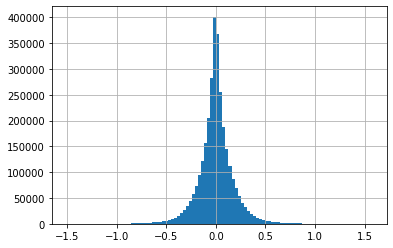

In [188]:
df.p_y_g1.hist(bins=100)

<AxesSubplot:>

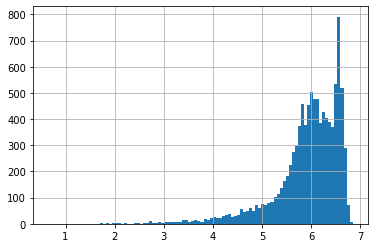

In [181]:
pd.Series(inputs[:,2]).hist(bins=100)

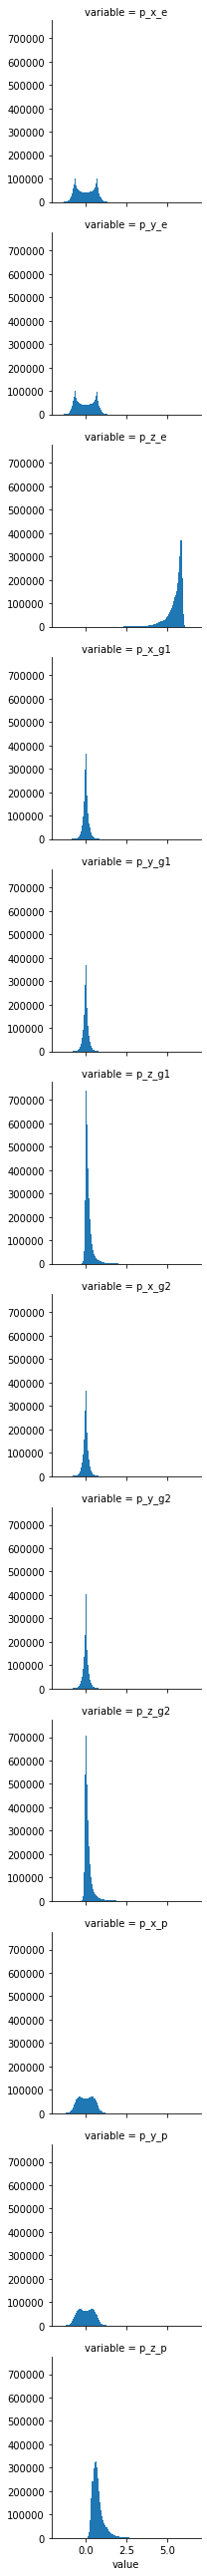

In [37]:
g = sns.FacetGrid(df.melt(), row='variable')
g.map(plt.hist, 'value', bins=100)